# Forecast Station Notebook 

`ForecastStation` inherits from `station`, it adds the ability to forecast the measures available at a station. 

## Initialisation 

To initialise a `ForecastStation` object you simply need to pass a valid StationReference / Station ID to the constructor. `parameter` and `qualifier` arguments are available which will filter the measures available at the station similar to how the different station classes are initialised. 

In [1]:
from flood_monitoring import ForecastStation

In [2]:
forecast_station = ForecastStation('1412') 

## Attributes 

After fitting our model a `model` attribute is appended to the `ForecastStation` object. 

# Methods 

### `load_data` 

`load_data` which takes in a measure_notation and a date range and provides all of the readings back as a Pandas DataFrame. `load_data` usings `get_readings` method inherited from the `station` class to perform the API call and then transforms the result into a DataFrame. 

In [3]:
#selecting one of the measures available at the station 
measure = forecast_station.measures[0] 
measure_notation = forecast_station.measures[0].notation

In [4]:
readings_df = forecast_station.load_data(measure_notation) 

Pritning the first 5 rows of the readings dataframe. 

In [5]:
readings_df.head() 

,dateTime,measure,value
0,2025-06-07T00:00:00Z,http://environment.data.gov.uk/flood-monitorin...,9.9
1,2025-06-07T01:00:00Z,http://environment.data.gov.uk/flood-monitorin...,9.9
2,2025-06-07T02:00:00Z,http://environment.data.gov.uk/flood-monitorin...,9.7
3,2025-06-07T03:00:00Z,http://environment.data.gov.uk/flood-monitorin...,9.5
4,2025-06-07T04:00:00Z,http://environment.data.gov.uk/flood-monitorin...,9.5


### `transfom_data` 

`transform_data` is a staticmethod which is used to transform the readings dataframe into train/test arrays for the Linear Regression model. 

Args: 

`dataframe` : dataframe storing readings 

`lag_features` : defines the number of previous readings which are included within each training sample. no. lag features is euqal to the number of previous values used to predict the next. 

`evaluation_split` : Bool, flag indicates whether or not the returned arrays should be split into train and test, False is default 

`split_date` : str, if `evaluation_split` is True. values `split_date` is placed into the training data and values after are in the evaluation set. 

`split_size` : int, if `evaluation_split` is True, split_size means that the latest n values defined by split_size will be placed into the evaluation set. 

In [6]:
X,y = forecast_station.transform_data(readings_df, lag_features = 3 ) 

/Users/rooprn01/flood-monitoring/src/flood_monitoring/forecast.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['dateTime64'] = pd.to_datetime(dataframe.dateTime)


In [7]:
X.shape 

(18, 3)

17 is the number of samples and 3 is number of previous values in each sample which we defined to be 3. 

Calling the function again with `evaluation_split` set to True and `split_size` set to 20 

In [8]:
x_train, y_train, x_test, y_test, test_timestamps  = forecast_station.transform_data(readings_df, lag_features = 3, evaluation_split = True, split_size = 5) 

/Users/rooprn01/flood-monitoring/src/flood_monitoring/forecast.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['dateTime64'] = pd.to_datetime(dataframe.dateTime)


Where `x_test` stores the last 3 values inside of the training data, as they will be used to forecast into the test set 

In [9]:
x_test

array([11.3, 13.2, 10.7])

`test_timestamps` stores the timestamps of the values within our test set

In [10]:
test_timestamps 

array(['2025-06-07T07:00:00Z', '2025-06-07T06:00:00Z',
       '2025-06-07T05:00:00Z', '2025-06-07T04:00:00Z',
       '2025-06-07T03:00:00Z'], dtype=object)

### `fit`

Calling `fit` instantiates and fits an scikit-learn `LinearRegression` Model to the X,y parameters passed to the method 

In [11]:
forecast_station.fit(x_train, y_train)

### `Predict`

`predict` function performs autoregressive inference, where the value predicted is then fed into the nex prediction. 

The number of predictions produced is defined by `n_predictions` and `x_test` is the previous k values prior to the ones we which to predict.

In [12]:
predictions = forecast_station.predict(x_test, n_predictions = 5 ) 

In [13]:
predictions

array([12.01714527, 12.91587637, 10.53111389, 12.67764829, 12.40039697])

### `visualise_predictions`

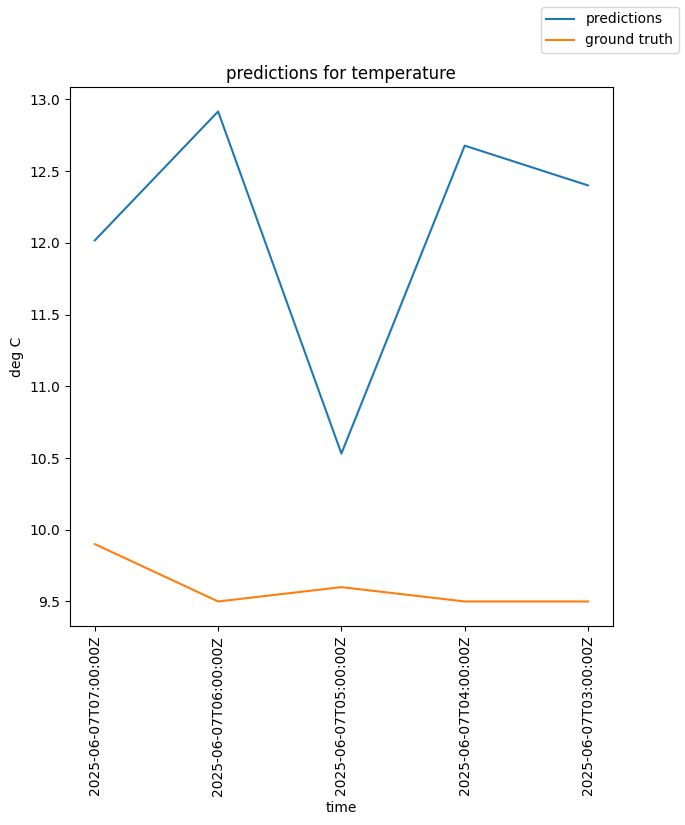

In [14]:
fig,ax  = forecast_station.visualise_predictions(predictions = predictions, 
                                ground_truth = y_test, 
                                test_timestamps = test_timestamps, 
                                measure = measure ) 

### `evaluate_forecast`

method which strings all of the previous methods together to to perform a full evaluation and plot a figure. The function takes a given measure which we want to forecast, a date range for training/eval, either splti_size or split date and finally lag features which define the number of previous values we will be using to forecast future values. 

/Users/rooprn01/flood-monitoring/src/flood_monitoring/forecast.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['dateTime64'] = pd.to_datetime(dataframe.dateTime)


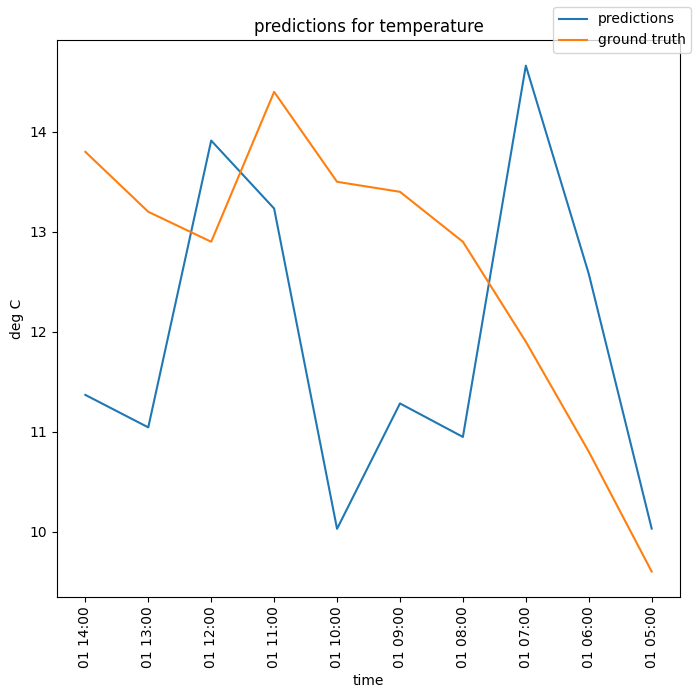

In [19]:
forecast_station.evaluate_forecast(measure, ['2025-06-01', '2025-06-07'], split_size = 10, lag_features = 5 )